# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW5


---
__Name:__  *Jennifer Casper*   
__Class:__ MIDS w261 (Section Fall 2017 Group 2)     
__Email:__  jenncasper@berkeley.edu     
__Week:__   5

__Due Time:__ 2 Phases. 

* __HW5 Phase 1__ 
This can be done on a local machine (with a unit test on the cloud such as AltaScale's PaaS or on AWS) and is due Tuesday, Week 6 by 8AM (West coast time). It will primarily focus on building a unit/systems and for pairwise similarity calculations pipeline (for stripe documents)

* __HW5 Phase 2__ 
This will require the AltaScale cluster and will be due Tuesday, Week 7 by 8AM (West coast time). 
The focus of  HW5 Phase 2  will be to scale up the unit/systems tests to the Google 5 gram corpus. This will be a group exercise 


# Table of Contents <a name="TOC"></a> 

1.  [HW Instructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
       
    5.4.  [HW5.4](#5.4)    
    5.5.  [HW5.5](#5.5)    
    5.6.  [HW5.6](#5.6)    
    5.7.  [HW5.7](#5.7)    
    5.8.  [HW5.8](#5.8)    
    5.9.  [HW5.9](#5.9)    
   

<a name="1"></a>
# 1 Instructions
[Back to Table of Contents](#TOC)

MIDS UC Berkeley, Machine Learning at Scale   
DATSCIW261 ASSIGNMENT #5

Version 2017-9-2 


### IMPORTANT

This homework must be completed in the cloud 

### === INSTRUCTIONS for SUBMISSIONS ===   
Follow the instructions for submissions carefully.

Each student has a `HW-<user>` repository for all assignments.   

Click this link to enable you to create a github repo within the MIDS261 Classroom:   
https://classroom.github.com/assignment-invitations/3b1d6c8e58351209f9dd865537111ff8   
and follow the instructions to create a HW repo.

Push the following to your HW github repo into the master branch:
* Your local HW5 directory. Your repo file structure should look like this:

```
HW-<user>
    --HW3
       |__MIDS-W261-HW-03-<Student_id>.ipynb
       |__MIDS-W261-HW-03-<Student_id>.pdf
       |__some other hw3 file
    --HW4
       |__MIDS-W261-HW-04-<Student_id>.ipynb
       |__MIDS-W261-HW-04-<Student_id>.pdf
       |__some other hw4 file
    etc..
```    

<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* See async and live lectures for this week

<a name="3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

<a name="5.4"></a> 
# PHASE 2 (~90hrs total)
----------

# HW 5.4   
## Full-scale experiment on Google N-gram data on the CLOUD
__ Once you are happy with your test results __ proceed to generating  your results on the Google n-grams dataset. 

## 3.  HW5.4.0  <a name="5.4.0"></a> Run systems tests on the CLOUD  (PHASE 2) (~10hrs)
[Back to Table of Contents](#TOC)

Repeat HW5.3.0 (using the same small data sources that were used in HW5.3.0) on ** the cloud** (e.g., AltaScale / AWS/ SoftLayer/ Azure). Make sure all tests give correct results! Good luck out there!

### Rework buildStripes.py for -r hadoop

In [153]:
%%writefile buildStripes.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys, itertools
#from collections import Counter
from collections import defaultdict

class MRbuildStripes(MRJob):
  
    MRJob.SORT_VALUES = True
    
    # purpose: only need a mapper to coordinate ngram pairs with the count and reducer to combine   
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1',
        }
        return [
            MRStep(jobconf = JOBCONF_STEP,
                   mapper=self.mapper,
                   reducer=self.reducer,
            )
        ]
    
    # purpose: split out the word pair counts for the ngrams
    # input: line from ngram input file - ngram \t count \t page count \t book count
    # output: key(word in ngram), value(dict of remaining ngram words with counts)
    def mapper(self, _, line):
        line = line.strip().split('\t')
        # capture the n-gram words
        words = line[0].lower().split()        
        # capture the count, pages_count, books_count values; only keep the count for use
        count = int(line[1:][0])
        # handle any ngrams with duplicate words
        #total_inst = dict(Counter(words)) -> MRJob -r hadoop no likie Counter
        total_inst = defaultdict(int)
        for w in words:
            total_inst[w] += 1
        # init the dictionary for emitting
        H = {}
        
        # note the set will remove duplicate words in the ngram list - how should this be handled?
        for subset in itertools.combinations(sorted(set(words)), 2):
            # check the first in the pair and only keep the count
            if subset[0] not in H.keys():
                H[subset[0]] = {}
                H[subset[0]][subset[1]] = total_inst[subset[1]] * count
            elif subset[1] not in H[subset[0]]:
                H[subset[0]][subset[1]] = total_inst[subset[1]] * count
            else:
                H[subset[0]][subset[1]] += (total_inst[subset[1]] * count)
                
            # check the second in the pair to capture the symmetry relationship
            if subset[1] not in H.keys():
                H[subset[1]] = {}
                H[subset[1]][subset[0]] = total_inst[subset[1]] * count
            elif subset[0] not in H[subset[1]]:
                H[subset[1]][subset[0]] = total_inst[subset[1]] * count
            else:
                H[subset[1]][subset[0]] += (total_inst[subset[1]] * count)
 
        for key in H.keys():
            yield key, (H[key])
    
    # purpose: combine the sorted-by-key mapper outputs into stripes
    # input: key(word in ngram), value(dict of remaining ngram words with counts)
    # output: key(word in ngram), value(dict of remaining ngram words with total counts)
    def reducer(self, key, value):
        #d = Counter() -> MRJob with -r hadoop hates Counter
        d = defaultdict(int)
        for item in value:
            #item = {k:int(v) for k, v in item.iteritems()}
            #d = d + Counter(item)
            for k, v in item.iteritems():
                d[k] += int(v)
        yield key, dict(d)

if __name__ == '__main__':
    MRbuildStripes.run()

Overwriting buildStripes.py


In [154]:
# test buildStripes.py locally after making the changes needed for -r hadoop
!python buildStripes.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt #> test_stripes.txt

No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/buildStripes.jenncasper.20171011.235433.668538
Running step 1 of 1...
Streaming final output from /tmp/buildStripes.jenncasper.20171011.235433.668538/output...
"a"	{"limited":55,"bill":59,"sea":62,"study":604,"child's":1099,"the":124,"collection":239,"general":92,"female":447,"in":1201,"establishing":59,"religious":59,"george":92,"biography":92,"case":604,"city":62,"circumstantial":62,"for":59,"of":1011,"tales":123,"government":102,"by":62,"forms":116,"narrative":62,"wales":1099,"fairy":123,"christmas":1099}
"bill"	{"a":59,"religious":59,"for":59,"establishing":59}
"biography"	{"a":92,"of":92,"george":92,"general":92}
"by"	{"a":62,"city":62,"the":62,"sea":62}
"case"	{"a":604,"limited":55,"female":447,"government":102,"of":502,"study":604,"in":102}
"child's"	{"a":1099,"wales":1099,"christmas":10

### Prepare invertedIndex.py for -r hadoop

In [155]:
%%writefile invertedIndex.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys, ast

class MRinvertedIndex(MRJob):
    
    MRJob.SORT_VALUES = True
    
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1',
        }
        return [
            MRStep(jobconf = JOBCONF_STEP,
                   mapper = self.mapper,
                   reducer = self.reducer,
            )
        ]  

    # purpose: split out the word pair counts for the ngrams
    # input: line from stripes file
    # output: key(word in ngram), value(doc and doc lengths)
    def mapper(self, _, line):
        # splice out the input from the stripes file      
        items = line.strip().split('\t')
        doc = items[0].replace("\"","")
        stripe = ast.literal_eval(items[1])
        # determine the ngram length and output
        length = len(stripe.keys())
        for word, cnt in sorted(stripe.iteritems()):
            yield word, (doc, length)
    
    # purpose: take the sorted input and prep for output
    # input: key(word in ngram), value(doc and doc lengths)
    # output: key(word in ngram), value(list of doc and doc lengths)
    def reducer(self, word, doc_len_list):
        doc_lens = [i for i in doc_len_list]
        yield word, doc_lens    

if __name__ == '__main__':
    MRinvertedIndex.run() 

Overwriting invertedIndex.py


In [166]:
# test invertedIndex.py locally after making the changes needed for -r hadoop
!python invertedIndex.py -r local test_stripes.txt #> test_index.txt

No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/invertedIndex.jenncasper.20171009.170026.003995
Running step 1 of 1...
Streaming final output from /tmp/invertedIndex.jenncasper.20171009.170026.003995/output...
"a"	[["bill",4],["biography",4],["by",4],["case",7],["child's",4],["christmas",4],["circumstantial",4],["city",4],["collection",5],["establishing",4],["fairy",4],["female",4],["for",4],["forms",3],["general",4],["george",4],["government",4],["in",7],["limited",4],["narrative",4],["of",15],["religious",4],["sea",4],["study",7],["tales",4],["the",7],["wales",4]]
"bill"	[["a",27],["establishing",4],["for",4],["religious",4]]
"biography"	[["a",27],["general",4],["george",4],["of",15]]
"by"	[["a",27],["city",4],["sea",4],["the",7]]
"case"	[["a",27],["female",4],["government",4],["in",7],["limited",4],["of",15],["study",7]]
"child's"	[["a",2

### Set up similarity.py to test on the small samples

In [150]:
%%writefile similarity.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRsimilarity(MRJob):

    MRJob.SORT_VALUES = True 
    
    def steps(self):
        JOBCONF_STEP1 = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1',
        }
        JOBCONF_STEP2 = { 
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1nr',
        }
        return [MRStep(jobconf = JOBCONF_STEP1,
                    mapper = self.mapper_pair_sim,
                    reducer = self.reducer_pair_sim,
                ),
                MRStep(jobconf = JOBCONF_STEP2,
                    mapper = None,   
                    reducer = self.reducer_sort,
                )
        ]
    
    # purpose: break apart the doc mappings and calculate a partial similarity for each pair
    def mapper_pair_sim(self, _, line):
        line = line.strip()
        index, posting = line.split("\t")
        posting = json.loads(posting)
        
        # build out all of the document pairs for the line
        for subset in itertools.combinations(posting, 2):
            # output the values necessary for jaccard and similarity calculations
            doc1 = subset[0][0]
            doc2 = subset[1][0]
            # for jaccard
            inter_cnt = 1
            doc1_len = subset[0][1]
            doc2_len = subset[1][1]
            # for cosine
            product = (1 / math.sqrt(doc1_len)) * (1 / math.sqrt(doc2_len))

            yield sorted([doc1, doc2]), (inter_cnt, doc1_len, doc2_len, product)

    # purpose: sum the partial similarities
    def reducer_pair_sim(self, key, value):
        
        inter_cnt = 0
        cosine = 0
        d = {}
        
        # sum for final dist values
        final_key = key[0] + ' - ' + key[1]
        for i in value:
            inter_cnt += i[0]
            doc1_len = i[1]
            doc2_len = i[2]
            cosine += i[3]
        jaccard = inter_cnt / (doc1_len + doc2_len - inter_cnt)
        # overlap - size of the intersection divided by the smaller of the size of the two sets  
        overlap = inter_cnt / min(doc1_len, doc2_len)
        # dice - 2 times the intersection divided by the sum of the two set sizes
        dice = (2 * inter_cnt) / (doc1_len + doc2_len)
        
        # similarity value results
        d['cosine'] = cosine
        d['jaccard'] = jaccard
        d['overlap'] = overlap
        d['dice'] = dice
        
        # similarity average
        avg = np.mean(d.values())

        yield avg, (final_key, d)
    
    # purpose: sort the final output by the avg or other dist value
    def reducer_sort(self, key, value):
        for v in value:
            yield key, v

if __name__ == '__main__':
    MRsimilarity.run()

Overwriting similarity.py


In [151]:
# test similarity.py locally after making the changes needed for -r hadoop
!python similarity.py -r local test_index.txt | sort -k1,1nr #> test_similarity.txt

No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/similarity.jenncasper.20171011.235010.572998
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/similarity.jenncasper.20171011.235010.572998/output...
Removing temp directory /tmp/similarity.jenncasper.20171011.235010.572998...
1.0	["female - limited",{"cosine":1.0,"dice":1.0,"overlap":1.0,"jaccard":1.0}]
0.8682920652	["fairy - forms",{"cosine":0.8660254038,"dice":0.8571428571,"overlap":1.0,"jaccard":0.75}]
0.8682920652	["forms - tales",{"cosine":0.8660254038,"dice":0.8571428571,"overlap":1.0,"jaccard":0.75}]
0.8303571429	["case - study",{"cosine":0.8571428574,"dice":0.8571428571,"overlap":0.8571428571,"jaccard":0.75}]
0.7125	["bill - establishing",{"cosine":0.75,"dice":0.75,"overlap":0.75,"jaccard":0.6}]
0.7125	["bill - for",{"cosine":0.75,"dice":0.75,"overlap":0.75

#### 1: unit/systems test first-10-lines

In [55]:
%%writefile googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt
A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative of the	62	62	50
A City by the Sea	62	60	49
A Collection of Fairy Tales	123	117	80
A Collection of Forms of	116	103	82

Writing googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt


#### 2: unit/systems test atlas-boon

In [56]:
%%writefile atlas-boon-systems-test.txt
atlas boon	50	50	50
boon cava dipped	10	10	10
atlas dipped	15	15	15

Overwriting atlas-boon-systems-test.txt


#### 3: systems test stripes-docs

In [70]:
########################################################################
# Stripes for systems test 3 (given, no need to build stripes)
########################################################################

with open("systems_test_stripes_3", "w") as f:
    f.writelines([
        '"DocA"\t{"X":20, "Y":30, "Z":5}\n',
        '"DocB"\t{"X":100, "Y":20}\n',  
        '"DocC"\t{"M":5, "N":20, "Z":5, "Y":1}\n'
    ])
!cat systems_test_stripes_3 

"DocA"	{"X":20, "Y":30, "Z":5}
"DocB"	{"X":100, "Y":20}
"DocC"	{"M":5, "N":20, "Z":5, "Y":1}


### 1) Build the stripes for the 3 tests

In [3]:
# setup the HDFS variables and pathes per James' example
import os
USER = !whoami
USER = USER[0]
OUTPUT_PATH_BASE = '/user/{USER}'.format(USER=USER)

In [4]:
# list the output directories
!hadoop fs -ls /user/jenncasper

Found 8 items
drwx------   - jenncasper users          0 2017-10-13 00:55 /user/jenncasper/.Trash
drwx------   - jenncasper users          0 2017-10-12 06:26 /user/jenncasper/.staging
drwxr-xr-x   - jenncasper users          0 2017-09-27 20:17 /user/jenncasper/apps
drwxr-xr-x   - jenncasper users          0 2017-10-11 22:56 /user/jenncasper/hw540_outputs
drwxr-xr-x   - jenncasper users          0 2017-10-11 14:24 /user/jenncasper/hw541_outputs
drwxr-xr-x   - jenncasper users          0 2017-10-13 00:55 /user/jenncasper/hw550_outputs
drwxr-xr-x   - jenncasper users          0 2017-10-09 01:06 /user/jenncasper/tests
drwxr-xr-x   - jenncasper users          0 2017-10-04 16:14 /user/jenncasper/tmp


In [126]:
# buildStripes for systems_test_stripes_1
!hadoop fs -rm -r hw540_outputs/systems_test_stripes_1
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'hw540_outputs/systems_test_stripes_1')
!python buildStripes.py \
    -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt \
    --output-dir={OUTPUT_PATH} \
    --no-output

17/10/11 22:25:01 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/hw540_outputs/systems_test_stripes_1' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/.Trash/Current
No configs found; falling back on auto-configuration
Creating temp directory /tmp/buildStripes.jenncasper.20171011.222503.547584
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/buildStripes.jenncasper.20171011.222503.547584/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partitio

In [127]:
# check the output for systems_test_stripes_1
!hadoop fs -ls {OUTPUT_PATH}/
!hadoop fs -cat {OUTPUT_PATH}/*

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-11 22:26 /user/jenncasper/hw540_outputs/systems_test_stripes_1/_SUCCESS
-rw-r--r--   3 jenncasper users       2408 2017-10-11 22:26 /user/jenncasper/hw540_outputs/systems_test_stripes_1/part-00000
"a"	{"limited": 55, "bill": 59, "sea": 62, "study": 604, "government": 102, "collection": 239, "general": 92, "female": 447, "in": 1201, "establishing": 59, "religious": 59, "george": 92, "biography": 92, "case": 604, "city": 62, "circumstantial": 62, "fairy": 123, "for": 59, "of": 1011, "tales": 123, "child's": 1099, "by": 62, "forms": 116, "narrative": 62, "wales": 1099, "the": 124, "christmas": 1099}
"bill"	{"a": 59, "religious": 59, "for": 59, "establishing": 59}
"biography"	{"a": 92, "of": 92, "george": 92, "general": 92}
"by"	{"a": 62, "city": 62, "the": 62, "sea": 62}
"case"	{"a": 604, "limited": 55, "female": 447, "government": 102, "of": 502, "study": 604, "in": 102}
"child's"	{"a": 1099, "wales": 1099, "christmas": 109

In [128]:
# buildStripes for systems_test_stripes_2
!hadoop fs -rm -r hw540_outputs/systems_test_stripes_2
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'hw540_outputs/systems_test_stripes_2')
!python buildStripes.py \
    -r hadoop atlas-boon-systems-test.txt \
    --output-dir={OUTPUT_PATH} \
    --no-output

17/10/11 22:29:24 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/hw540_outputs/systems_test_stripes_2' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/.Trash/Current
No configs found; falling back on auto-configuration
Creating temp directory /tmp/buildStripes.jenncasper.20171011.222926.646931
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/buildStripes.jenncasper.20171011.222926.646931/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partitio

In [129]:
# check the output for systems_test_stripes_2
!hadoop fs -ls {OUTPUT_PATH}/
!hadoop fs -cat {OUTPUT_PATH}/*

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-11 22:30 /user/jenncasper/hw540_outputs/systems_test_stripes_2/_SUCCESS
-rw-r--r--   3 jenncasper users        163 2017-10-11 22:30 /user/jenncasper/hw540_outputs/systems_test_stripes_2/part-00000
"atlas"	{"dipped": 15, "boon": 50}
"boon"	{"atlas": 50, "dipped": 10, "cava": 10}
"cava"	{"dipped": 10, "boon": 10}
"dipped"	{"atlas": 15, "boon": 10, "cava": 10}


In [73]:
# stripes for systems_test_stripes_3 ready in the file

### 2) Build the inverted indexes for the 3 tests and pretty print the output kept in HDFS

In [130]:
# invertedIndex for systems_test_index_1
!hadoop fs -rm -r hw540_outputs/systems_test_index_1
INPUT_PATH = os.path.join('hdfs:///', OUTPUT_PATH_BASE[1:],'hw540_outputs/systems_test_stripes_1')
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE, 'hw540_outputs/systems_test_index_1')
!python invertedIndex.py \
    -r hadoop {INPUT_PATH} \
    --output-dir={OUTPUT_PATH} \
    --no-output

17/10/11 22:31:40 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/hw540_outputs/systems_test_index_1' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/invertedIndex.jenncasper.20171011.223142.447836
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/invertedIndex.jenncasper.20171011.223142.447836/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partitio

In [131]:
# check the output for systems_test_index_1
!hadoop fs -ls {OUTPUT_PATH}/
!hadoop fs -cat {OUTPUT_PATH}/*

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-11 22:33 /user/jenncasper/hw540_outputs/systems_test_index_1/_SUCCESS
-rw-r--r--   3 jenncasper users       2508 2017-10-11 22:33 /user/jenncasper/hw540_outputs/systems_test_index_1/part-00000
"a"	[["of", 15], ["government", 4], ["in", 7], ["wales", 4], ["narrative", 4], ["general", 4], ["forms", 3], ["limited", 4], ["religious", 4], ["the", 7], ["george", 4], ["sea", 4], ["study", 7], ["tales", 4], ["by", 4], ["collection", 5], ["for", 4], ["case", 7], ["female", 4], ["biography", 4], ["child's", 4], ["bill", 4], ["fairy", 4], ["christmas", 4], ["circumstantial", 4], ["establishing", 4], ["city", 4]]
"bill"	[["establishing", 4], ["for", 4], ["a", 27], ["religious", 4]]
"biography"	[["of", 15], ["general", 4], ["george", 4], ["a", 27]]
"by"	[["city", 4], ["a", 27], ["the", 7], ["sea", 4]]
"case"	[["of", 15], ["study", 7], ["in", 7], ["government", 4], ["limited", 4], ["a", 27], ["female", 4]]
"child's"	[["christmas", 4], 

In [132]:
# invertedIndex for systems_test_index_2
!hadoop fs -rm -r hw540_outputs/systems_test_index_2
INPUT_PATH = os.path.join('hdfs:///', OUTPUT_PATH_BASE[1:],'hw540_outputs/systems_test_stripes_2')
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE, 'hw540_outputs/systems_test_index_2')
!python invertedIndex.py \
    -r hadoop {INPUT_PATH} \
    --output-dir={OUTPUT_PATH} \
    --no-output

17/10/11 22:35:11 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/hw540_outputs/systems_test_index_2' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/invertedIndex.jenncasper.20171011.223512.374619
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/invertedIndex.jenncasper.20171011.223512.374619/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partitio

In [134]:
# check the output for systems_test_index_2
!hadoop fs -ls {OUTPUT_PATH}/
!hadoop fs -cat {OUTPUT_PATH}/*

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-11 22:36 /user/jenncasper/hw540_outputs/systems_test_index_2/_SUCCESS
-rw-r--r--   3 jenncasper users        173 2017-10-11 22:36 /user/jenncasper/hw540_outputs/systems_test_index_2/part-00000
"atlas"	[["boon", 3], ["dipped", 3]]
"boon"	[["dipped", 3], ["cava", 2], ["atlas", 2]]
"cava"	[["boon", 3], ["dipped", 3]]
"dipped"	[["cava", 2], ["boon", 3], ["atlas", 2]]


In [137]:
# invertedIndex for systems_test_index_3
!hadoop fs -rm -r hw540_outputs/systems_test_index_3
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE, 'hw540_outputs/systems_test_index_3')
!python invertedIndex.py \
    -r hadoop systems_test_stripes_3 \
    --output-dir={OUTPUT_PATH} \
    --no-output

17/10/11 22:40:09 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/hw540_outputs/systems_test_index_3' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/.Trash/Current
No configs found; falling back on auto-configuration
Creating temp directory /tmp/invertedIndex.jenncasper.20171011.224010.362737
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/invertedIndex.jenncasper.20171011.224010.362737/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partitio

In [138]:
# check the output for systems_test_index_3
!hadoop fs -ls {OUTPUT_PATH}/
!hadoop fs -cat {OUTPUT_PATH}/*

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-11 22:41 /user/jenncasper/hw540_outputs/systems_test_index_3/_SUCCESS
-rw-r--r--   3 jenncasper users        142 2017-10-11 22:41 /user/jenncasper/hw540_outputs/systems_test_index_3/part-00000
"M"	[["DocC", 4]]
"N"	[["DocC", 4]]
"X"	[["DocB", 2], ["DocA", 3]]
"Y"	[["DocB", 2], ["DocA", 3], ["DocC", 4]]
"Z"	[["DocC", 4], ["DocA", 3]]


In [140]:
##########################################################
# Pretty print systems tests for generating Inverted Index from HDFS
##########################################################

import json
import subprocess

for i in range(1,4):
    print "—"*90
    print "Systems test ",i," - Inverted Index"
    print "—"*90  
    
    INDEX_PATH = os.path.join(OUTPUT_PATH_BASE, 'hw540_outputs/systems_test_index_'+str(i), '*')
    cat = subprocess.Popen(["hadoop", "fs", "-cat", INDEX_PATH], stdout=subprocess.PIPE)
    for line in cat.stdout:
        line = line.strip()
        word,stripe = line.split("\t")
        stripe = sorted(json.loads(stripe))
        stripe.extend([["",""] for _ in xrange(3 - len(stripe))])
        print "{0:>16} |{1:>16} |{2:>16} |{3:>16}".format((word), 
                                                          stripe[0][0]+" "+str(stripe[0][1]), 
                                                          stripe[1][0]+" "+str(stripe[1][1]), 
                                                          stripe[2][0]+" "+str(stripe[2][1]))
        cat.wait()
            

——————————————————————————————————————————————————————————————————————————————————————————
Systems test  1  - Inverted Index
——————————————————————————————————————————————————————————————————————————————————————————
             "a" |          bill 4 |     biography 4 |            by 4
          "bill" |            a 27 |  establishing 4 |           for 4
     "biography" |            a 27 |       general 4 |        george 4
            "by" |            a 27 |          city 4 |           sea 4
          "case" |            a 27 |        female 4 |    government 4
       "child's" |            a 27 |     christmas 4 |            in 7
     "christmas" |            a 27 |       child's 4 |            in 7
"circumstantial" |            a 27 |     narrative 4 |           of 15
          "city" |            a 27 |            by 4 |           sea 4
    "collection" |            a 27 |         fairy 4 |         forms 3
  "establishing" |            a 27 |          bill 4 |           for 4
   

### 3) Calculate the similarities for the 3 tests and pretty print the output kept in HDFS

In [141]:
# similarities for systems_test_similarities_1
!hadoop fs -rm -r hw540_outputs/systems_test_similarities_1
INPUT_PATH = os.path.join('hdfs:///', OUTPUT_PATH_BASE[1:],'hw540_outputs/systems_test_index_1')
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE, 'hw540_outputs/systems_test_similarities_1')
!python similarity.py \
    -r hadoop {INPUT_PATH} \
    --output-dir={OUTPUT_PATH} \
    --no-output

17/10/11 22:44:25 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/hw540_outputs/systems_test_similarities_1' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/similarity.jenncasper.20171011.224427.480024
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/similarity.jenncasper.20171011.224427.480024/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partiti

In [144]:
# check the output for systems_test_similarities_1
!hadoop fs -ls {OUTPUT_PATH}/
!hadoop fs -cat {OUTPUT_PATH}/*

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-11 22:46 /user/jenncasper/hw540_outputs/systems_test_similarities_1/_SUCCESS
-rw-r--r--   3 jenncasper users      50923 2017-10-11 22:46 /user/jenncasper/hw540_outputs/systems_test_similarities_1/part-00000
1.0	["female - limited", {"cosine": 1.0, "dice": 1.0, "overlap": 1.0, "jaccard": 1.0}]
0.86829206523182401	["fairy - forms", {"cosine": 0.86602540378443882, "dice": 0.8571428571428571, "overlap": 1.0, "jaccard": 0.75}]
0.86829206523182401	["forms - tales", {"cosine": 0.86602540378443882, "dice": 0.8571428571428571, "overlap": 1.0, "jaccard": 0.75}]
0.83035714285714279	["case - study", {"cosine": 0.85714285714285687, "dice": 0.8571428571428571, "overlap": 0.8571428571428571, "jaccard": 0.75}]
0.71250000000000002	["bill - for", {"cosine": 0.75, "dice": 0.75, "overlap": 0.75, "jaccard": 0.59999999999999998}]
0.71250000000000002	["christmas - wales", {"cosine": 0.75, "dice": 0.75, "overlap": 0.75, "jaccard": 0.599999999999

In [145]:
# similarities for systems_test_similarities_2
!hadoop fs -rm -r hw540_outputs/systems_test_similarities_2
INPUT_PATH = os.path.join('hdfs:///', OUTPUT_PATH_BASE[1:],'hw540_outputs/systems_test_index_2')
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE, 'hw540_outputs/systems_test_similarities_2')
!python similarity.py \
    -r hadoop {INPUT_PATH} \
    --output-dir={OUTPUT_PATH} \
    --no-output

17/10/11 22:50:14 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/hw540_outputs/systems_test_similarities_2' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/similarity.jenncasper.20171011.225015.728342
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/similarity.jenncasper.20171011.225015.728342/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partiti

In [146]:
# check the output for systems_test_similarities_2
!hadoop fs -ls {OUTPUT_PATH}/
!hadoop fs -cat {OUTPUT_PATH}/*

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-11 22:52 /user/jenncasper/hw540_outputs/systems_test_similarities_2/_SUCCESS
-rw-r--r--   3 jenncasper users        763 2017-10-11 22:52 /user/jenncasper/hw540_outputs/systems_test_similarities_2/part-00000
1.0	["atlas - cava", {"cosine": 0.99999999999999978, "dice": 1.0, "overlap": 1.0, "jaccard": 1.0}]
0.625	["boon - dipped", {"cosine": 0.66666666666666685, "dice": 0.66666666666666663, "overlap": 0.66666666666666663, "jaccard": 0.5}]
0.38956207261596576	["cava - dipped", {"cosine": 0.40824829046386302, "dice": 0.40000000000000002, "overlap": 0.5, "jaccard": 0.25}]
0.38956207261596576	["boon - cava", {"cosine": 0.40824829046386302, "dice": 0.40000000000000002, "overlap": 0.5, "jaccard": 0.25}]
0.38956207261596576	["atlas - dipped", {"cosine": 0.40824829046386302, "dice": 0.40000000000000002, "overlap": 0.5, "jaccard": 0.25}]
0.38956207261596576	["atlas - boon", {"cosine": 0.40824829046386302, "dice": 0.40000000000000002,

In [147]:
# similarities for systems_test_similarities_3
!hadoop fs -rm -r hw540_outputs/systems_test_similarities_3
INPUT_PATH = os.path.join('hdfs:///', OUTPUT_PATH_BASE[1:],'hw540_outputs/systems_test_index_3')
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE, 'hw540_outputs/systems_test_similarities_3')
!python similarity.py \
    -r hadoop {INPUT_PATH} \
    --output-dir={OUTPUT_PATH} \
    --no-output

17/10/11 22:55:03 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/hw540_outputs/systems_test_similarities_3' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/similarity.jenncasper.20171011.225504.488275
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/similarity.jenncasper.20171011.225504.488275/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partiti

In [148]:
# check the output for systems_test_similarities_3
!hadoop fs -ls {OUTPUT_PATH}/
!hadoop fs -cat {OUTPUT_PATH}/*

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-11 22:56 /user/jenncasper/hw540_outputs/systems_test_similarities_3/_SUCCESS
-rw-r--r--   3 jenncasper users        453 2017-10-11 22:56 /user/jenncasper/hw540_outputs/systems_test_similarities_3/part-00000
0.82079081189859815	["DocA - DocB", {"cosine": 0.81649658092772603, "dice": 0.80000000000000004, "overlap": 1.0, "jaccard": 0.66666666666666663}]
0.55386137682121594	["DocA - DocC", {"cosine": 0.57735026918962584, "dice": 0.5714285714285714, "overlap": 0.66666666666666663, "jaccard": 0.40000000000000002}]
0.34672168098165174	["DocB - DocC", {"cosine": 0.35355339059327373, "dice": 0.33333333333333331, "overlap": 0.5, "jaccard": 0.20000000000000001}]


In [149]:
############################################
# Pretty print systems tests from HDFS
############################################

import json, ast
import subprocess

for i in range(1,4):
    print '—'*110
    print "Systems test ",i," - Similarity measures"
    print '—'*110
    print "{0:>10} |{1:>20} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
          "average", "pair", "cosine", "jaccard", "overlap", "dice")
    print '-'*110

    INDEX_PATH = os.path.join(OUTPUT_PATH_BASE, 'hw540_outputs/systems_test_similarities_'+str(i), '*')
    cat = subprocess.Popen(["hadoop", "fs", "-cat", INDEX_PATH], stdout=subprocess.PIPE)
    for line in cat.stdout:
        line = line.strip()
        avg, stripe = line.split("\t")
        pair, dist_dict = json.loads(stripe)
            
        print "{0:>10f} |{1:>20} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
            float(avg), pair, float(dist_dict['cosine']), float(dist_dict['jaccard']), 
            float(dist_dict['overlap']), float(dist_dict['dice']))
            
        cat.wait()

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  1  - Similarity measures
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
   average |                pair |         cosine |        jaccard |        overlap |           dice
--------------------------------------------------------------------------------------------------------------
  1.000000 |    female - limited |       1.000000 |       1.000000 |       1.000000 |       1.000000
  0.868292 |       fairy - forms |       0.866025 |       0.750000 |       1.000000 |       0.857143
  0.868292 |       forms - tales |       0.866025 |       0.750000 |       1.000000 |       0.857143
  0.830357 |        case - study |       0.857143 |       0.750000 |       0.857143 |       0.857143
  0.712500 |          bill - for |       0.750000 |       0.600000 |       0.750000 |       0.750000
  0.712500 |   christm

  1.000000 |        atlas - cava |       1.000000 |       1.000000 |       1.000000 |       1.000000
  0.625000 |       boon - dipped |       0.666667 |       0.500000 |       0.666667 |       0.666667
  0.389562 |       cava - dipped |       0.408248 |       0.250000 |       0.500000 |       0.400000
  0.389562 |         boon - cava |       0.408248 |       0.250000 |       0.500000 |       0.400000
  0.389562 |      atlas - dipped |       0.408248 |       0.250000 |       0.500000 |       0.400000
  0.389562 |        atlas - boon |       0.408248 |       0.250000 |       0.500000 |       0.400000
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  3  - Similarity measures
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
   average |                pair |         cosine |        jaccard |        overlap |           dice
--------------------------------

## 3.  HW5.4.1 <a name="5.4.1"></a>Full-scale experiment: EDA of Google n-grams dataset (PHASE 2) (~14hrs)
[Back to Table of Contents](#TOC)

Do some EDA on this dataset using mrjob, e.g., 

- A. Longest 5-gram (number of characters)
- B. Top 10 most frequent words (please use the count information), i.e., unigrams
- C. 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- D. Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

In [48]:
# scope out the ngrams input files
!hadoop fs -count /user/winegarj/data/full
!hadoop fs -count -q -h /user/winegarj/data/full/* | sort -k7,7n
# 2 of the 190 files are empty?

           1          190         2156069116 /user/winegarj/data/full
        none             inf            none             inf            0            1                  0 /user/winegarj/data/full/googlebooks-eng-all-5gram-20090715-1-filtered.txt
        none             inf            none             inf            0            1                  0 /user/winegarj/data/full/googlebooks-eng-all-5gram-20090715-46-filtered.txt
        none             inf            none             inf            0            1             10.9 M /user/winegarj/data/full/googlebooks-eng-all-5gram-20090715-0-filtered.txt
        none             inf            none             inf            0            1             10.9 M /user/winegarj/data/full/googlebooks-eng-all-5gram-20090715-10-filtered.txt
        none             inf            none             inf            0            1             10.9 M /user/winegarj/data/full/googlebooks-eng-all-5gram-20090715-101-filtered.txt
        none         

### HW5.4.1 - A. Longest 5-gram (number of characters)

In [192]:
%%writefile longest5gram.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class longest5gram(MRJob):
    
    # START STUDENT CODE 5.4.1.A

    MRJob.SORT_VALUES = True
    
    # purpose: need a mapper, combiner, and reducer in this case
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1',
        }
        return [
            MRStep(jobconf = JOBCONF_STEP,
                   mapper = self.mapper,
                   combiner = self.combiner,
                   reducer = self.reducer,
            )
        ]
    
    # purpose: figure out the length in chars of each ngram
    # input: key(None), value(ngram\tcount\tpage\tbook)
    # output: key(None), value(ngram string, length of ngram string)
    def mapper(self, _, line):
        ngram, count, page, book = line.lower().strip().split("\t")
        yield None, (ngram, len(ngram))
    
    # purpose: find the max length ngram
    # input: key(None), value(ngram string, length of ngram string)
    # output: key(None), value(max ngram string, max length of ngram string)
    def combiner(self, _, data):
        yield None, max(data, key=lambda item: item[1])
    
    # purpose: find the max length ngram across all mappers
    def reducer(self, _, data):
        yield max(data, key=lambda item: item[1])
        
    # END STUDENT CODE 5.4.1.A
    
if __name__ == '__main__':
    longest5gram.run()

Overwriting longest5gram.py


__On test data set:__

In [193]:
# test longest5gram.py locally on the google sample
!python longest5gram.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt

No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/longest5gram.jenncasper.20171009.180015.001257
Running step 1 of 1...
Streaming final output from /tmp/longest5gram.jenncasper.20171009.180015.001257/output...
"a bill for establishing religious"	33
Removing temp directory /tmp/longest5gram.jenncasper.20171009.180015.001257...


__On full data set:__

In [194]:
# longest5gram.py on the full data set
!hadoop fs -rm -r hw541_outputs/longest5gram
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE, 'hw541_outputs/longest5gram')
!python longest5gram.py \
    -r hadoop hdfs:///user/winegarj/data/full/ \
    --output-dir={OUTPUT_PATH} \
    --no-output

rm: `hw541_outputs/longest5gram': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/longest5gram.jenncasper.20171009.180351.831061
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/longest5gram.jenncasper.20171009.180351.831061/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob8502973787240079983.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/ti

In [196]:
# check longest5gram.py output
!hadoop fs -ls {OUTPUT_PATH}
!hadoop fs -cat {OUTPUT_PATH}/*

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-09 18:19 /user/jenncasper/hw541_outputs/longest5gram/_SUCCESS
-rw-r--r--   3 jenncasper users        166 2017-10-09 18:19 /user/jenncasper/hw541_outputs/longest5gram/part-00000
"aiopjumrxuyvaslyhypsibemapodikr ufrydiuuolbigasuaurusrexlisnaye rnoondqsrunsubunougrabberyairtc utahraptoredileipmilbdummyuveri syevrahvelocyallosauruslinrotsr"	159


### Report stats for longest5gram

## Longest 5grams MR stats


__Step 1:__  

    CPU time spent (ms)=6939920  
    Map tasks = 192
    Reduce tasks = 1 
    
__Step 2:__   

    N/A  

### HW5.4.1 - B. Top 10 most frequent words 

In [66]:
# get the nltk stopwords
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jenncasper/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
%%writefile mostFrequentWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import defaultdict

class mostFrequentWords(MRJob):
    
    # START STUDENT CODE 5.4.1.B
    
    MRJob.SORT_VALUES = True
    
    # purpose: steps needed to find the top 10 most frequent words
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1',
        }
        JOBCONF_STEP2 = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1nr',
        }
        
        return [
            MRStep(jobconf = JOBCONF_STEP,
                   mapper_init = self.mapper_init,
                   mapper = self.mapper,
                   mapper_final = self.mapper_final,
                   combiner = self.combiner,
                   reducer = self.reducer,
            ),
            MRStep(jobconf = JOBCONF_STEP2,
                   mapper = None,
                   reducer = self.reducer_sort,  
            ),
        ]
    
    # purpose: define the mapper's dict used to track word freq
    def mapper_init(self):
        self.word_counts = defaultdict(int)
        self.stopWords = [sw for sw in open('english').read().strip().split('\n')]
    
    # purpose: split the line and capture the count for each ngram word
    # input: key(None), value(ngram\tcount\tpage\tbook)
    # output: nothing; counts are stored in the mapper's internal dict word_counts
    def mapper(self, _, line):
        ngram, count, page, book = line.lower().strip().split("\t")
        # drop word if it is an nltk stopword
        for word in ngram.split(' '):
            if word not in self.stopWords:
                self.word_counts[word] += int(count)
            
    # purpose: emit the word and count pairs to the combiner for summing counts for each word
    # input: use the mapper's internal word_counts dict
    # output: key(word), value(count for the word emitted from the mapper)
    def mapper_final(self):
        for word, count in self.word_counts.iteritems():
            yield word, count
    
    # purpose: sum up the counts for the same words processed by a mapper
    # input: key(word), value(count for the word emitted from the mapper)
    # output: key(word), value(sum of the word's counts)
    def combiner(self, word, count):
        yield word, sum(count)
    
    # purpose: sum up all of the word counts across the mappers
    # input: key(word), value(sum of the word's counts from the combiners)
    # output: key(sum of the word's counts), value(word)
    def reducer(self, word, count):
        #yield None, (int(sum(count)), word)
        yield sum(count), word
    
    # purpose: get the sorted outputs
    def reducer_sort(self, count, word):
        for w in word:
            yield count, w
    
    # END STUDENT CODE 5.4.1.B
        
if __name__ == '__main__':
    mostFrequentWords.run()

Overwriting mostFrequentWords.py


__On the test data set:__

In [3]:
# test mostFrequentWords.py locally on the google sample dropping stopwords
!python mostFrequentWords.py -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt --file english #| sort -k1,1nr

No configs found; falling back on auto-configuration
Creating temp directory /tmp/mostFrequentWords.jenncasper.20171011.141345.092184
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/mostFrequentWords.jenncasper.20171011.141345.092184/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob4411733989974011021.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s

__On the full data set:__

In [8]:
# mostFrequentWords.py on the full data set
!hadoop fs -rm -r hw541_outputs/mostFrequentWords
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE, 'hw541_outputs/mostFrequentWords')
!python mostFrequentWords.py \
    -r hadoop hdfs:///user/winegarj/data/full/ \
    --file english \
    --output-dir={OUTPUT_PATH} \
    --no-output

rm: `hw541_outputs/mostFrequentWords': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/mostFrequentWords.jenncasper.20171011.141946.761004
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/mostFrequentWords.jenncasper.20171011.141946.761004/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob7683168149773987239.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.co

Removing temp directory /tmp/mostFrequentWords.jenncasper.20171011.141946.761004...


In [13]:
# check mostFrequentWords.py output and get the top 10
!hadoop fs -ls {OUTPUT_PATH}
!printf "Top 10 most frequent words with stopwords dropped:\n"
!hadoop fs -cat {OUTPUT_PATH}/* | head -10

# write the top 9k most frequent words to a file for use later
!hadoop fs -cat {OUTPUT_PATH}/* | head -9000 > mostFrequent_10k

# crop the last 1k lines of mostFrequent_10k as basis for vocab to use later
!hadoop fs -cat {OUTPUT_PATH}/* | head -10000 | tail -1000 > leastmostFrequent_1k

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-11 14:25 /user/jenncasper/hw541_outputs/mostFrequentWords/_SUCCESS
-rw-r--r--   3 jenncasper users    4156343 2017-10-11 14:25 /user/jenncasper/hw541_outputs/mostFrequentWords/part-00000
Top 10 most frequent words with stopwords dropped:
180195771	"one"
139313915	"would"
126853684	"time"
108486904	"may"
79528921	"part"
78780613	"could"
78089800	"first"
74978840	"made"
72793319	"way"
68693179	"two"
cat: Unable to write to output stream.
cat: Unable to write to output stream.


## Most frequent words MR stats

    
__Step 1:__   

    CPU time spent (ms)=2647090   
    Launched map tasks=192  
    Launched reduce tasks=1   

__Step 2:__  

    CPU time spent (ms)=15290   
    Launched map tasks=2
    Launched reduce tasks=1  


### HW5.4.1 - C. 20 Most/Least densely appearing words 

In [36]:
%%writefile mostLeastDenseWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-
from __future__ import division
import re
import numpy as np
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import defaultdict

class mostLeastDenseWords(MRJob):
    
    # START STUDENT CODE 5.4.1.C
    
    MRJob.SORT_VALUES = True
    
    # purpose: we are defining dense as counts per page
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1',
        }
        JOBCONF_STEP2 = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1nr',
        }
        
        return [
            MRStep(jobconf = JOBCONF_STEP,
                   mapper_init = self.mapper_init,
                   mapper = self.mapper,
                   mapper_final = self.mapper_final,
                   combiner = self.combiner,
                   reducer = self.reducer,
            ),
            MRStep(jobconf = JOBCONF_STEP2,
                   mapper = None,
                   reducer = self.reducer_sort,  
            ),
        ]
    
    # purpose: define the mapper's dict used to track count and pages
    def mapper_init(self):
        self.word_counts = defaultdict(int)
        self.word_pages = defaultdict(int)
    
    # purpose: split the line and capture the count and pages for each ngram word
    # input: key(None), value(ngram\tcount\tpage\tbook)
    # output: nothing; counts and pages are stored in the mapper's internal dicts
    def mapper(self, _, line):
        ngram, count, page, book = line.lower().strip().split("\t")
        for word in ngram.split(' '):
            self.word_counts[word] += int(count)
            self.word_pages[word] += int(page)
            
    # purpose: emit the word counts and pages pairs to the combiner for summing counts and pages for each word
    # input: use the mapper's internal dicts
    # output: key(word), value(count and pages for the word emitted from the mapper)
    def mapper_final(self):
        for word, count in self.word_counts.iteritems():
            yield word, (count, self.word_pages[word])
    
    # purpose: sum up the counts and pages for the same words processed by a mapper
    # input: key(word), value(count and pages for the word emitted from the mapper)
    # output: key(word), value(sum of the word's counts and pages)
    def combiner(self, word, counts):
        c = [i for i in counts]
        count = sum([i[0] for i in c])
        pages = sum([i[1] for i in c])
        yield word, (count, pages)

    # purpose: sum up all of the word counts and pages across the mappers
    # input: key(word), value(sum of the word's counts and pages)
    # output: key(word), calculated density
    def reducer(self, word, counts):
        c = [i for i in counts]
        count = sum([i[0] for i in c])
        pages = sum([i[1] for i in c])
        yield (float(count)/pages), word
    
    # purpose: get the sorted outputs
    def reducer_sort(self, density, word):
        for w in word:
            yield density, w  
    
    # END STUDENT CODE 5.4.1.C
        
if __name__ == '__main__':
    mostLeastDenseWords.run()

Overwriting mostLeastDenseWords.py


__On the test data set:__

In [43]:
# test mostLeastDenseWords.py locally on the google sample
!python mostLeastDenseWords.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt | sort -k1,1nr

No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/mostLeastDenseWords.jenncasper.20171011.103123.743509
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/mostLeastDenseWords.jenncasper.20171011.103123.743509/output...
Removing temp directory /tmp/mostLeastDenseWords.jenncasper.20171011.103123.743509...
1.1262135922	"forms"
1.0863636364	"collection"
1.0512820513	"fairy"
1.0512820513	"tales"
1.0358152686	"child's"
1.0358152686	"christmas"
1.0358152686	"wales"
1.0348004094	"of"
1.0333333333	"by"
1.0333333333	"city"
1.0333333333	"sea"
1.0326741187	"in"
1.0282931354	"a"
1.0222222222	"biography"
1.0222222222	"general"
1.0222222222	"george"
1.0163934426	"the"
1.0	"bill"
1.0	"case"
1.0	"circumstantial"
1.0	"establishing"
1.0	"female"
1.0	"for"
1.0	"government"
1.0	"limited"
1.0	"narrative"
1.0	"religious"
1.0	"study"


__On the full data set:__

In [38]:
# mostLeastDenseWords.py on the full data set
!hadoop fs -rm -r hw541_outputs/mostLeastDenseWords
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE, 'hw541_outputs/mostLeastDenseWords')
!python mostLeastDenseWords.py \
    -r hadoop hdfs:///user/winegarj/data/full/ \
    --output-dir={OUTPUT_PATH} \
    --no-output

rm: `hw541_outputs/mostLeastDenseWords': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/mostLeastDenseWords.jenncasper.20171011.101905.692471
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/mostLeastDenseWords.jenncasper.20171011.101905.692471/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob4856495035958724215.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altisc

Removing temp directory /tmp/mostLeastDenseWords.jenncasper.20171011.101905.692471...


In [44]:
# check mostFrequentWords.py output and get the top 10
!hadoop fs -ls {OUTPUT_PATH}
!printf "Most frequent: \n"
!hadoop fs -cat {OUTPUT_PATH}/* | head -1
!printf "Least frequent: \n" 
!hadoop fs -cat {OUTPUT_PATH}/* | tail -1

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-11 10:25 hdfs:/user/jenncasper/hw541_outputs/mostLeastDenseWords/_SUCCESS
-rw-r--r--   3 jenncasper users    6135569 2017-10-11 10:25 hdfs:/user/jenncasper/hw541_outputs/mostLeastDenseWords/part-00000
Most frequent: 
11.557291666666666	"xxxx"
cat: Unable to write to output stream.
Least frequent: 
1.0	"lawton's"


## Word density MR stats
    
__Step 1:__ 

    CPU time spent (ms)=3107220  
    Launched map tasks=191  
    Launched reduce tasks=1     

__Step 2:__  

    CPU time spent (ms)=18150    
    Launched map tasks=2   
    Launched reduce tasks=1   

### HW5.4.1 - D. Distribution of 5-gram sizes (character length)

In [49]:
%%writefile distribution.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class distribution(MRJob):
    
    # START STUDENT CODE 5.4.1.D
    
    MRJob.SORT_VALUES = True
    
    # purpose: need a mapper, combiner, and reducer in this case
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1n',
        }
        return [
            MRStep(jobconf = JOBCONF_STEP,
                   mapper = self.mapper,
                   combiner = self.combiner,
                   reducer = self.reducer,
            )
        ]
    
    # purpose: emit ngram length counts
    # input: key(None), value(ngram\tcount\tpage\tbook)
    # output: key(ngram length), value(1)
    def mapper(self, _, line):
        ngram, count, page, book = line.lower().strip().split("\t")
        yield len(ngram), 1
    
    # purpose: sum the ngram length counts for mappers
    # input: key(ngram length), value(1)
    # output: key(ngram length), value(count)
    def combiner(self, length, count):
        yield int(length), sum(count)
    
    # purpose: sum the ngram length counts across mappers
    def reducer(self, length, count):
        yield int(length), sum(count)
    
    # END STUDENT CODE 5.4.1.D
    
if __name__ == '__main__':
    distribution.run()

Overwriting distribution.py


__On the test data set:__

In [50]:
# test distribution.py locally on the google sample
!python distribution.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt 

No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/distribution.jenncasper.20171011.104329.451361
Running step 1 of 1...
Streaming final output from /tmp/distribution.jenncasper.20171011.104329.451361/output...
17	1
22	1
23	1
24	1
26	1
27	1
28	1
29	1
33	2
Removing temp directory /tmp/distribution.jenncasper.20171011.104329.451361...


__On the full data set:__

In [51]:
# distribution.py on the full data set
!hadoop fs -rm -r hw541_outputs/distribution
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE, 'hw541_outputs/distribution')
!python distribution.py \
    -r hadoop hdfs:///user/winegarj/data/full/ \
    --output-dir={OUTPUT_PATH} \
    --no-output

rm: `hw541_outputs/distribution': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/distribution.jenncasper.20171011.104508.107314
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/distribution.jenncasper.20171011.104508.107314/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob2460263134155880238.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/ti

In [54]:
# check distribution.py output and get the top 10
!hadoop fs -ls {OUTPUT_PATH}
!hadoop fs -cat {OUTPUT_PATH}/* > distributions.txt

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-11 10:47 /user/jenncasper/hw541_outputs/distribution/_SUCCESS
-rw-r--r--   3 jenncasper users        624 2017-10-11 10:47 /user/jenncasper/hw541_outputs/distribution/part-00000


## Distribution MRJob stats

__Step 1:__ 

    CPU time spent (ms)=3687080  
    Launched map tasks=191  
    Launched reduce tasks=1   
    
__Step 2:__  

    N/A  

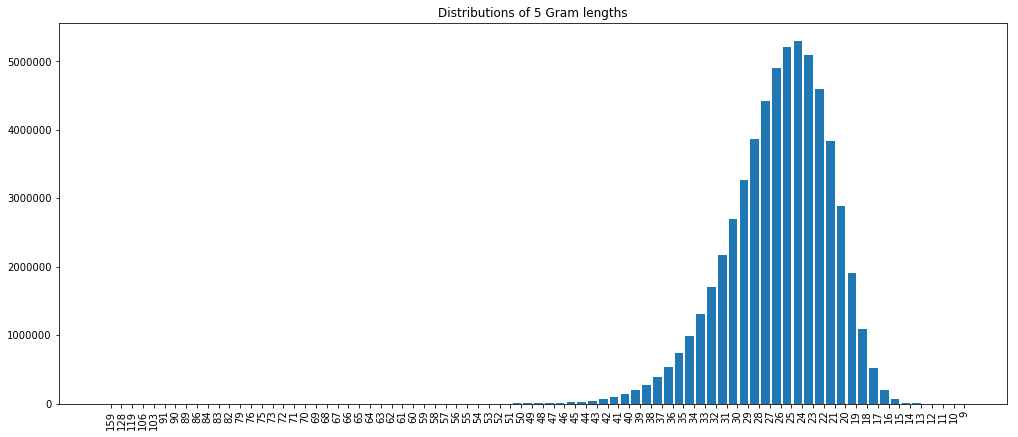

In [55]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("distributions.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths")
pl.show()

## 3.  HW5.4.2 <a name="5.4.2"></a>OPTIONAL Question: log-log plots (PHASE 2)
[Back to Table of Contents](#TOC)

Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
- https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
- https://en.wikipedia.org/wiki/Power_law

## 3.  HW5.5  <a name="5.5"></a> Synonym detection over 2Gig of Data with extra Preprocessing steps (HW5.3 plus some preprocessing)   (Phase 2) (~60 hrs)
[Back to Table of Contents](#TOC)

For the remainder of this assignment please feel free to eliminate stop words from your analysis

>There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
 stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with your system.

In this part of the assignment we will focus on developing methods for detecting synonyms, using the Google 5-grams dataset. At a high level:


1. remove stopwords
2. get 10,0000 most frequent
3. get 1000 (9001-10000) features
3. build stripes

To accomplish this you must script two main tasks using MRJob:


__TASK (1)__ Build stripes for the most frequent 10,000 words using cooccurence information based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


__TASK (2)__ Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

#### Design notes for TASK (1)
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for TASK (2).

#### Design notes for _TASK (2)_
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

## Example MR stats: (report times!)
    took ~11 minutes on 5 m3.xlarge nodes
    Data-local map tasks=188
	Launched map tasks=190
	Launched reduce tasks=15
	Other local map tasks=2

In [ ]:
# START STUDENT CODE 5.5
# ADD OR REMOVE CELLS AS NEEDED

In [88]:
%%writefile buildStripes10k.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys, itertools
from collections import defaultdict

class MRbuildStripes10k(MRJob):
  
    MRJob.SORT_VALUES = True
    
    # purpose: produce stripes for the most frequent words only - use a combiner to reduce traffic   
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1',
            'mapreduce.tasktracker.map.tasks.maximum' : 40,  
            'mapreduce.tasktracker.reduce.tasks.maximum' : 40,
        }
        return [
            MRStep(jobconf = JOBCONF_STEP,
                   mapper_init = self.mapper_init,
                   mapper = self.mapper,
                   combiner = self.combiner,
                   reducer = self.reducer,
            )
        ]
    
    def mapper_init(self):
        # get the list of keeper words from the previously produced mostFrequent_10k
        self.keeper_words = [kw.split('\t')[1].strip('"') for kw in open('mostFrequent_10k').read().strip().split('\n')]
        # get the list of keeper words from the previously produced mostFrequent_10k
        self.vocab_words = [kw.split('\t')[1].strip('"') for kw in open('leastmostFrequent_1k').read().strip().split('\n')]
        
    # purpose: split out the word pair counts for the ngrams
    # input: line from ngram input file - ngram \t count \t page count \t book count
    # output: key(word in ngram), value(dict of remaining ngram words with counts)
    def mapper(self, _, line):
        line = line.strip().split('\t')
        # capture the n-gram words
        words = line[0].lower().split()
        # only keep the words that are in the keeper_words list
        kwords = [w for w in words if w in self.keeper_words]
        # capture the count, pages_count, books_count values; only keep the count for use
        #count = int(line[1:][0])
        # use a count of 1 for capturing the instance
        count = 1
        # handle any ngrams with duplicate words
        total_inst = defaultdict(int)
        for w in kwords:
            total_inst[w] += 1
        # init the dictionary for emitting
        H = {}
        
        # there has got to be a quicker/better way to do this
        for w1, w2 in itertools.combinations(sorted(set(kwords)), 2):
            # check the first in the pair and only keep the count
            if (w1 not in self.vocab_words) and (w2 in self.vocab_words):
                if w1 not in H.keys():
                    H[w1] = {}
                    H[w1][w2] = total_inst[w2] * count
                elif w2 not in H[w1]:
                    H[w1][w2] = total_inst[w2] * count
                else:
                    H[w1][w2] += (total_inst[w2] * count)
                
            # check the reverse pair to capture the symmetry relationship
            if (w2 not in self.vocab_words) and (w1 in self.vocab_words):
                if w2 not in H.keys():
                    H[w2] = {}
                    H[w2][w1] = total_inst[w2] * count
                elif w1 not in H[w2]:
                    H[w2][w1] = total_inst[w2] * count
                else:
                    H[w2][w1] += (total_inst[w2] * count)
 
        for key in H.keys():
            yield key, (H[key])

    # purpose: combine the sorted-by-key mapper outputs into stripes for each mapper
    # input: key(word in ngram), value(dict of remaining ngram words with counts)
    # output: key(word in ngram), value(dict of remaining ngram words with total counts)
    def combiner(self, key, value):
        d = defaultdict(int)
        for item in value:
            for k, v in item.iteritems():
                d[k] += int(v)
        yield key, dict(d)
    
    # purpose: combine the stripes across mappers
    # input: key(word in ngram), value(dict of remaining ngram words with total counts)
    # output: key(word in ngram), value(dict of remaining ngram words with total counts)
    def reducer(self, key, value):
        d = defaultdict(int)
        for item in value:
            for k, v in item.iteritems():
                d[k] += int(v)
        yield key, dict(d)

if __name__ == '__main__':
    MRbuildStripes10k.run()

Overwriting buildStripes10k.py


In [75]:
# check for functionality by running local
!python buildStripes10k.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt --file mostFrequent_10k  --file leastmostFrequent_1k > systems_test_stripes

No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/buildStripes10k.jenncasper.20171011.190648.400501
Running step 1 of 1...
Streaming final output from /tmp/buildStripes10k.jenncasper.20171011.190648.400501/output...
Removing temp directory /tmp/buildStripes10k.jenncasper.20171011.190648.400501...


In [72]:
# check that the test works for hadoop
!hadoop fs -rm -r hw550_outputs/systems_test_stripes
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'hw550_outputs/systems_test_stripes')
!python buildStripes10k.py \
    -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt \
    --file mostFrequent_10k \
    --file leastmostFrequent_1k \
    --output-dir={OUTPUT_PATH} \
    --no-output

17/10/11 18:46:01 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/hw550_outputs/systems_test_stripes' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/.Trash/Current
No configs found; falling back on auto-configuration
Creating temp directory /tmp/buildStripes10k.jenncasper.20171011.184603.296590
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/buildStripes10k.jenncasper.20171011.184603.296590/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.part

In [7]:
#!hadoop fs -cat /user/jenncasper/hw550_outputs/stripes_10k/* | wc -l

8997


In [73]:
# check buildStripes10k.py test output
!hadoop fs -ls {OUTPUT_PATH}
!hadoop fs -cat {OUTPUT_PATH}/*

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-11 18:46 /user/jenncasper/hw550_outputs/systems_test_stripes/_SUCCESS
-rw-r--r--   3 jenncasper users        786 2017-10-11 18:46 /user/jenncasper/hw550_outputs/systems_test_stripes/part-00000
"bill"	{"religious": 1, "establishing": 1}
"biography"	{"george": 1, "general": 1}
"case"	{"limited": 1, "study": 3, "female": 1, "government": 1}
"child's"	{"wales": 1, "christmas": 1}
"christmas"	{"wales": 1, "child's": 1}
"city"	{"sea": 1}
"collection"	{"forms": 1, "fairy": 1, "tales": 1}
"establishing"	{"bill": 1, "religious": 1}
"fairy"	{"tales": 1, "collection": 1}
"female"	{"case": 1, "study": 1}
"forms"	{"collection": 1}
"general"	{"george": 1, "biography": 1}
"george"	{"biography": 1, "general": 1}
"government"	{"case": 1, "study": 1}
"limited"	{"case": 1, "study": 1}
"religious"	{"bill": 1, "establishing": 1}
"sea"	{"city": 1}
"study"	{"case": 3, "limited": 1, "female": 1, "government": 1}
"tales"	{"fairy": 1, "collection"

In [63]:
# buildStripes10k.py for all data
!hadoop fs -rm -r hw550_outputs/stripes_10k
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'hw550_outputs/stripes_10k')
!python buildStripes10k.py \
    -r hadoop hdfs:///user/winegarj/data/full/ \
    --file mostFrequent_10k \
    --file leastmostFrequent_1k \
    --output-dir={OUTPUT_PATH} \
    --no-output

17/10/11 18:18:44 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/hw550_outputs/stripes_10k' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/buildStripes10k.jenncasper.20171011.181845.941475
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/buildStripes10k.jenncasper.20171011.181845.941475/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partition.key

In [69]:
# check the output for the strips_10k
!hadoop fs -ls -h {OUTPUT_PATH}
!hadoop fs -cat {OUTPUT_PATH}/* | head -1

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-11 18:38 /user/jenncasper/hw550_outputs/stripes_10k/_SUCCESS
-rw-r--r--   3 jenncasper users      8.7 M 2017-10-11 18:38 /user/jenncasper/hw550_outputs/stripes_10k/part-00000
"ab"	{"conveying": 273, "chord": 1006, "parallels": 89, "subscribed": 44, "binary": 76, "residential": 77, "consul": 48, "amplifier": 91, "ce": 58, "terminals": 141, "narratives": 89, "est": 256, "qui": 1445, "lever": 77, "wires": 51}
cat: Unable to write to output stream.


### buildStripes10k stats

    Reduce output records=8997
    CPU time spent (ms)=51460120
    Rack-local map tasks=198
	Launched map tasks=200
	Launched reduce tasks=1
	Other local map tasks=2

In [74]:
%%writefile invertedIndex10k.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys, ast

class MRinvertedIndex10k(MRJob):
    
    MRJob.SORT_VALUES = True
    
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1',
        }
        return [
            MRStep(jobconf = JOBCONF_STEP,
                   mapper = self.mapper,
                   reducer = self.reducer,
            )
        ]  

    # purpose: split out the word pair counts for the ngrams
    # input: line from stripes file
    # output: key(word in ngram), value(doc and doc lengths)
    def mapper(self, _, line):
        # splice out the input from the stripes file      
        items = line.strip().split('\t')
        doc = items[0].replace("\"","")
        stripe = ast.literal_eval(items[1])
        # determine the ngram length and output
        length = len(stripe.keys())
        for word, cnt in sorted(stripe.iteritems()):
            yield word, (doc, length)
    
    # purpose: take the sorted input and prep for output
    # input: key(word in ngram), value(doc and doc lengths)
    # output: key(word in ngram), value(list of doc and doc lengths)
    def reducer(self, word, doc_len_list):
        doc_lens = [i for i in doc_len_list]
        yield word, doc_lens    

if __name__ == '__main__':
    MRinvertedIndex10k.run() 

Writing invertedIndex10k.py


In [99]:
# check for functionality by running local
!python invertedIndex10k.py -r local systems_test_stripes > systems_test_index

No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/invertedIndex10k.jenncasper.20171011.195401.056806
Running step 1 of 1...
Streaming final output from /tmp/invertedIndex10k.jenncasper.20171011.195401.056806/output...
Removing temp directory /tmp/invertedIndex10k.jenncasper.20171011.195401.056806...
20


In [78]:
# check that the test works for hadoop
!hadoop fs -rm -r hw550_outputs/systems_test_index
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'hw550_outputs/systems_test_index')
!python invertedIndex10k.py \
    -r hadoop hdfs:///user/jenncasper/hw550_outputs/systems_test_stripes \
    --output-dir={OUTPUT_PATH} \
    --no-output

rm: `hw550_outputs/systems_test_index': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/invertedIndex10k.jenncasper.20171011.191311.948799
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/invertedIndex10k.jenncasper.20171011.191311.948799/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob2236247771059410225.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com

In [98]:
# check the output for the index test
!hadoop fs -ls -h {OUTPUT_PATH}
!hadoop fs -cat {OUTPUT_PATH}/* 

20


In [82]:
# invertedIndex10k.py for all data
!hadoop fs -rm -r hw550_outputs/index_10k
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'hw550_outputs/index_10k')
!python invertedIndex10k.py \
    -r hadoop hdfs:///user/jenncasper/hw550_outputs/stripes_10k \
    --output-dir={OUTPUT_PATH} \
    --no-output

rm: `hw550_outputs/index_10k': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/invertedIndex10k.jenncasper.20171011.192506.259255
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/invertedIndex10k.jenncasper.20171011.192506.259255/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob9190715603547387903.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/

In [84]:
# check the output for the index_10k
!hadoop fs -ls -h {OUTPUT_PATH}
!hadoop fs -cat {OUTPUT_PATH}/* | wc -l

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-11 19:28 /user/jenncasper/hw550_outputs/index_10k/_SUCCESS
-rw-r--r--   3 jenncasper users      8.8 M 2017-10-11 19:28 /user/jenncasper/hw550_outputs/index_10k/part-00000
1000


### invertedIndex10k stats

    Reduce output records=1000
    CPU time spent (ms)=64870
    Rack-local map tasks=2
	Launched map tasks=2
	Launched reduce tasks=1
	Other local map tasks=0

In [1]:
%%writefile similarity10k.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRsimilarity10k(MRJob):

    MRJob.SORT_VALUES = True 
    
    def steps(self):
        JOBCONF_STEP1 = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1',
        }
        JOBCONF_STEP2 = { 
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1nr',
        }
        return [MRStep(jobconf = JOBCONF_STEP1,
                    mapper = self.mapper_pair_sim,
                    reducer = self.reducer_pair_sim,
                ),
                #MRStep(jobconf = JOBCONF_STEP2,
                #    mapper = None,   
                #    reducer = self.reducer_sort,
                #)
        ]
    
    # purpose: break apart the doc mappings and calculate a partial similarity for each pair
    def mapper_pair_sim(self, _, line):
        line = line.strip()
        index, posting = line.split("\t")
        posting = json.loads(posting)

        # build out all of the document pairs for the line
        for subset in itertools.combinations(posting, 2):
            # output the values necessary for jaccard and similarity calculations
            doc1 = subset[0][0]
            doc2 = subset[1][0]
            # for jaccard
            inter_cnt = 1
            doc1_len = subset[0][1]
            doc2_len = subset[1][1]
            # for cosine
            product = (1 / math.sqrt(doc1_len)) * (1 / math.sqrt(doc2_len))

            # order the doc names so the reducer gets the correct key packages
            yield (sorted([doc1, doc2])), (inter_cnt, doc1_len, doc2_len, product)


    # purpose: sum the partial similarities
    def reducer_pair_sim(self, key, value):
        
        inter_cnt = 0
        cosine = 0
        d = {}
        
        # sum for final dist values
        final_key = key[0] + ' - ' + key[1]
        for i in value:
            inter_cnt += i[0]
            doc1_len = i[1]
            doc2_len = i[2]
            cosine += i[3]
        jaccard = inter_cnt / (doc1_len + doc2_len - inter_cnt)
        # overlap - size of the intersection divided by the smaller of the size of the two sets  
        overlap = inter_cnt / min(doc1_len, doc2_len)
        # dice - 2 times the intersection divided by the sum of the two set sizes
        dice = (2 * inter_cnt) / (doc1_len + doc2_len)
        
        # similarity value results
        d['cosine'] = cosine
        d['jaccard'] = jaccard
        d['overlap'] = overlap
        d['dice'] = dice
        
        # similarity average
        avg = np.mean(d.values())

        yield float(d['cosine']), (final_key, avg, d)
    
    # purpose: sort the final output by the avg or other dist value
    def reducer_sort(self, key, value):
        # sort by cosine value
        for v in value:
            yield key, v

if __name__ == '__main__':
    MRsimilarity10k.run()

Overwriting similarity10k.py


In [189]:
# check for functionality by running local
!python similarity10k.py -r local systems_test_index | sort -k1,1nr

No configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/similarity10k.jenncasper.20171012.013832.933878
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/similarity10k.jenncasper.20171012.013832.933878/output...
Removing temp directory /tmp/similarity10k.jenncasper.20171012.013832.933878...
1.0	["female - government",1.0,{"cosine":1.0,"dice":1.0,"overlap":1.0,"jaccard":1.0}]
1.0	["female - limited",1.0,{"cosine":1.0,"dice":1.0,"overlap":1.0,"jaccard":1.0}]
1.0	["government - limited",1.0,{"cosine":1.0,"dice":1.0,"overlap":1.0,"jaccard":1.0}]
0.75	["case - study",0.7125,{"cosine":0.75,"dice":0.75,"overlap":0.75,"jaccard":0.6}]
0.7071067812	["fairy - forms",0.718443362,{"cosine":0.7071067812,"dice":0.6666666667,"overlap":1.0,"jaccard":0.5}]
0.7071067812	["forms - tales",0.718443362,{"cosine":0.7071067812,"dice":0.666666666

In [190]:
# check that the test works for hadoop
!hadoop fs -rm -r hw550_outputs/systems_test_similarities
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'hw550_outputs/systems_test_similarities')
!python similarity10k.py \
    -r hadoop hdfs:///user/jenncasper/hw550_outputs/systems_test_index \
    --output-dir={OUTPUT_PATH} \
    --no-output

17/10/12 01:38:50 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/hw550_outputs/systems_test_similarities' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/jenncasper/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/similarity10k.jenncasper.20171012.013851.598860
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/similarity10k.jenncasper.20171012.013851.598860/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.par

In [191]:
# check the output for the similarities test
!hadoop fs -ls -h {OUTPUT_PATH}
!hadoop fs -cat {OUTPUT_PATH}/* 

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-12 01:40 /user/jenncasper/hw550_outputs/systems_test_similarities/_SUCCESS
-rw-r--r--   3 jenncasper users      3.6 K 2017-10-12 01:40 /user/jenncasper/hw550_outputs/systems_test_similarities/part-00000
0.99999999999999978	["government - limited", 1.0, {"cosine": 0.99999999999999978, "dice": 1.0, "overlap": 1.0, "jaccard": 1.0}]
0.99999999999999978	["female - limited", 1.0, {"cosine": 0.99999999999999978, "dice": 1.0, "overlap": 1.0, "jaccard": 1.0}]
0.99999999999999978	["female - government", 1.0, {"cosine": 0.99999999999999978, "dice": 1.0, "overlap": 1.0, "jaccard": 1.0}]
0.75	["case - study", 0.71250000000000002, {"cosine": 0.75, "dice": 0.75, "overlap": 0.75, "jaccard": 0.59999999999999998}]
0.70710678118654746	["forms - tales", 0.7184433619633035, {"cosine": 0.70710678118654746, "dice": 0.66666666666666663, "overlap": 1.0, "jaccard": 0.5}]
0.70710678118654746	["fairy - forms", 0.7184433619633035, {"cosine": 0.707106

In [5]:
# similarity10k.py for all data
!hadoop fs -rm -r hw550_outputs/similarities_10k
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'hw550_outputs/similarities_10k')
!python similarity10k.py \
    -r hadoop hdfs:///user/jenncasper/hw550_outputs/index_10k \
    --output-dir={OUTPUT_PATH} \
    --no-output

rm: `hw550_outputs/similarities_10k': No such file or directory
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Creating temp directory /tmp/similarity10k.jenncasper.20171013.005638.684205
Using Hadoop version 2.7.3
Copying local files to hdfs:///user/jenncasper/tmp/mrjob/similarity10k.jenncasper.20171013.005638.684205/files/...
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob349648015288105209.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/

In [16]:
# check the output for the similarities test
!hadoop fs -ls -h {OUTPUT_PATH}
!hadoop fs -cat {OUTPUT_PATH}/* > similarities_sorted
!head -20 similarities_sorted > similarities_sorted_top20
!tail -20 similarities_sorted > similarities_sorted_bottom20
!head -1000 similarities_sorted > similarities_sorted_top1000

Found 2 items
-rw-r--r--   3 jenncasper users          0 2017-10-13 06:01 /user/jenncasper/hw550_outputs/similarities_10k/_SUCCESS
-rw-r--r--   3 jenncasper users      4.5 G 2017-10-13 06:01 /user/jenncasper/hw550_outputs/similarities_10k/part-00000


### similarity10k stats

    Map input records=1000
    Map output records=157512744
    Reduce input records=157512744
    Reduce output records=25453679
    CPU time spent (ms)=22818760
    Rack-local map tasks=2
	Launched map tasks=2
	Launched reduce tasks=1
	Other local map tasks=0

In [ ]:
# END STUDENT CODE 5.5

In [14]:
import json

print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

with open('similarities_sorted_top20', 'r') as f:
    for line in f:
        cosine, stripe = line.strip().split('\t')
        pair, avg, sim_dict = json.loads(stripe)
        print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(pair, 
                                                                                 float(sim_dict['cosine']), 
                                                                                 float(sim_dict['jaccard']), 
                                                                                 float(sim_dict['overlap']), 
                                                                                 float(sim_dict['dice']), 
                                                                                 float(avg))
        
print '—'*117

with open('similarities_sorted_bottom20', 'r') as f:
    for line in f:
        cosine, stripe = line.strip().split('\t')
        pair, avg, sim_dict = json.loads(stripe)
        print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(pair, 
                                                                                 float(sim_dict['cosine']), 
                                                                                 float(sim_dict['jaccard']), 
                                                                                 float(sim_dict['overlap']), 
                                                                                 float(sim_dict['dice']), 
                                                                                 float(avg))


Top/Bottom 20 results - Similarity measures - sorted by cosine
(From the entire data set)
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                          pair |         cosine |        jaccard |        overlap |           dice |        average
---------------------------------------------------------------------------------------------------------------------
                     may - one |       0.950675 |       0.905433 |       0.975081 |       0.950370 |       0.945390
                    one - time |       0.943432 |       0.891481 |       0.983221 |       0.942627 |       0.940190
                    one - well |       0.932641 |       0.872233 |       0.974157 |       0.931757 |       0.927697
                    may - well |       0.921278 |       0.853783 |       0.938202 |       0.921125 |       0.908597
                   first - one |       0.915763 |       0.840932 |       0.981087 |       0.9

### 5.5 NOTES

This was a hefty section that took a great deal of time and effort. If I grasped the req word and vocab concept and executed the 10K frequent words and 1K vocab correctly, the resulting pairs sorted by cosine differed from the example. Further time is needed to explore this as the pairs aren't particularly compelling. The NLTK stop words were used on the freq word list, but perhaps this was not enough.

In [ ]:
Top/Bottom 20 results - Similarity measures - sorted by cosine
(From the entire data set)
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                          pair |         cosine |        jaccard |        overlap |           dice |        average
---------------------------------------------------------------------------------------------------------------------
                   cons - pros |       0.894427 |       0.800000 |       1.000000 |       0.888889 |       0.895829
            forties - twenties |       0.816497 |       0.666667 |       1.000000 |       0.800000 |       0.820791
                    own - time |       0.809510 |       0.670563 |       0.921168 |       0.802799 |       0.801010
                 little - time |       0.784197 |       0.630621 |       0.926101 |       0.773473 |       0.778598
                  found - time |       0.783434 |       0.636364 |       0.883788 |       0.777778 |       0.770341
                 nova - scotia |       0.774597 |       0.600000 |       1.000000 |       0.750000 |       0.781149
                   hong - kong |       0.769800 |       0.615385 |       0.888889 |       0.761905 |       0.758995
                   life - time |       0.769666 |       0.608789 |       0.925081 |       0.756829 |       0.765091
                  time - world |       0.755476 |       0.585049 |       0.937500 |       0.738209 |       0.754058
                  means - time |       0.752181 |       0.587117 |       0.902597 |       0.739854 |       0.745437
                   form - time |       0.749943 |       0.588418 |       0.876733 |       0.740885 |       0.738995
       infarction - myocardial |       0.748331 |       0.560000 |       1.000000 |       0.717949 |       0.756570
                 people - time |       0.745788 |       0.573577 |       0.923875 |       0.729010 |       0.743063
                 angeles - los |       0.745499 |       0.586207 |       0.850000 |       0.739130 |       0.730209
                  little - own |       0.739343 |       0.585834 |       0.767296 |       0.738834 |       0.707827
                    life - own |       0.737053 |       0.582217 |       0.778502 |       0.735951 |       0.708430
          anterior - posterior |       0.733388 |       0.576471 |       0.790323 |       0.731343 |       0.707881
                  power - time |       0.719611 |       0.533623 |       0.933586 |       0.695898 |       0.720680
              dearly - install |       0.707107 |       0.500000 |       1.000000 |       0.666667 |       0.718443
                   found - own |       0.704802 |       0.544134 |       0.710949 |       0.704776 |       0.666165
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
           arrival - essential |       0.008258 |       0.004098 |       0.009615 |       0.008163 |       0.007534
         governments - surface |       0.008251 |       0.003534 |       0.014706 |       0.007042 |       0.008383
                king - lesions |       0.008178 |       0.003106 |       0.017857 |       0.006192 |       0.008833
              clinical - stood |       0.008178 |       0.003831 |       0.011905 |       0.007634 |       0.007887
               till - validity |       0.008172 |       0.003367 |       0.015625 |       0.006711 |       0.008469
            evidence - started |       0.008159 |       0.003802 |       0.012048 |       0.007576 |       0.007896
               forces - record |       0.008152 |       0.003876 |       0.011364 |       0.007722 |       0.007778
               primary - stone |       0.008146 |       0.004065 |       0.009091 |       0.008097 |       0.007350
             beneath - federal |       0.008134 |       0.004082 |       0.008403 |       0.008130 |       0.007187
                factors - rose |       0.008113 |       0.004032 |       0.009346 |       0.008032 |       0.007381
           evening - functions |       0.008069 |       0.004049 |       0.008333 |       0.008065 |       0.007129
                   bone - told |       0.008061 |       0.003704 |       0.012346 |       0.007380 |       0.007873
             building - occurs |       0.008002 |       0.003891 |       0.010309 |       0.007752 |       0.007489
                 company - fig |       0.007913 |       0.003257 |       0.015152 |       0.006494 |       0.008204
               chronic - north |       0.007803 |       0.003268 |       0.014493 |       0.006515 |       0.008020
             evaluation - king |       0.007650 |       0.003030 |       0.015625 |       0.006042 |       0.008087
             resulting - stood |       0.007650 |       0.003663 |       0.010417 |       0.007299 |       0.007257
                 agent - round |       0.007515 |       0.003289 |       0.012821 |       0.006557 |       0.007546
         afterwards - analysis |       0.007387 |       0.003521 |       0.010204 |       0.007018 |       0.007032
            posterior - spirit |       0.007156 |       0.002660 |       0.016129 |       0.005305 |       0.007812

## 3.  HW5.6  <a name="5.6"></a> Evaluation of synonyms that your discovered (~3 hr)
[Back to Table of Contents](#TOC)


In this part of the assignment you will evaluate the success of you synonym detector (developed in response to HW5.4).
Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in HW5.4, and use the synonyms function in the accompanying python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

### Calculate performance measures:
$$Precision (P) = \frac{TP}{TP + FP} $$  
$$Recall (R) = \frac{TP}{TP + FN} $$  
$$F1 = \frac{2 * ( precision * recall )}{precision + recall}$$


We calculate Precision by counting the number of hits and dividing by the number of occurances in our top1000 (opportunities)   
We calculate Recall by counting the number of hits, and dividing by the number of synonyms in wordnet (syns)


Other diagnostic measures not implemented here:  https://en.wikipedia.org/wiki/F1_score#Diagnostic_Testing

In [19]:
# get the nltk wordnet
import nltk

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jenncasper/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
''' Performance measures '''
from __future__ import division
import numpy as np
import json
import nltk
from nltk.corpus import wordnet as wn
import sys

#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()

hits = []

TP = 0
FP = 0

TOTAL = 0
flag = False # so we don't double count, but at the same time don't miss hits

top1000sims = []
with open("similarities_sorted_top1000","r") as f:
    for line in f.readlines():
        cosine, stripe = line.strip().split('\t')
        pair, avg, sim_dict = json.loads(stripe)
        lisst = [pair, avg]
        top1000sims.append(lisst)

        #line = line.strip()
        #avg,lisst = line.split("\t")
        #lisst = json.loads(lisst)
        #lisst.append(avg)
        #top1000sims.append(lisst)

measures = {}
not_in_wordnet = []

for line in top1000sims:
    TOTAL += 1

    pair = line[0]
    words = pair.split(" - ")
    #print words
    for word in words:
        if word not in measures:
            measures[word] = {"syns":0,"opps": 0,"hits":0}
        measures[word]["opps"] += 1 
    
    syns0 = synonyms(words[0])
    measures[words[1]]["syns"] = len(syns0)
    if len(syns0) == 0:
        not_in_wordnet.append(words[0])
        
    if words[1] in syns0:
        TP += 1
        hits.append(line)
        flag = True
        measures[words[1]]["hits"] += 1
        
    syns1 = synonyms(words[1]) 
    measures[words[0]]["syns"] = len(syns1)
    if len(syns1) == 0:
        not_in_wordnet.append(words[1])

    if words[0] in syns1:
        if flag == False:
            TP += 1
            hits.append(line)
            measures[words[0]]["hits"] += 1
            
    flag = False    

precision = []
recall = []
f1 = []

for key in measures:
    p,r,f = 0,0,0
    if measures[key]["hits"] > 0 and measures[key]["syns"] > 0:
        p = measures[key]["hits"]/measures[key]["opps"]
        r = measures[key]["hits"]/measures[key]["syns"]
        f = 2 * (p*r)/(p+r)
    
    # For calculating measures, only take into account words that have synonyms in wordnet
    if measures[key]["syns"] > 0:
        precision.append(p)
        recall.append(r)
        f1.append(f)

    
# Take the mean of each measure    
print "—"*110    
print "Number of Hits:",TP, "out of top",TOTAL
print "Number of words without synonyms:",len(not_in_wordnet)
print "—"*110 
print "Precision\t", np.mean(precision)
print "Recall\t\t", np.mean(recall)
print "F1\t\t", np.mean(f1)
print "—"*110  

print "Words without synonyms:"
print "-"*100

for word in not_in_wordnet:
    print synonyms(word),word

    

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 9 out of top 1000
Number of words without synonyms: 236
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.00385993574542
Recall		0.0187437502717
F1		0.00442760136946
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] would
[] would
[] would
[] upon
[] could
[] would
[] upon
[] would
[] would
[] upon
[] would
[] could
[] upon
[] would
[] would
[] could
[] upon
[] upon
[] could
[] would
[] would
[] would
[] would
[] upon
[] upon
[] would
[] could
[] could
[] would
[] upon
[] could
[] could
[] could
[] without
[] could
[] would
[] could
[] upon
[] hong
[] kong
[] without
[] upon
[] would
[] would
[] without


### 5.6 NOTES

The popular pairs resulting from the 10K most frequent words with the 1K vocabulary were still relatively common words which resulted in pairs that weren't particularly interesting. I would go back and adjust the frequent word constraints, as discussed in the sync slides, to see how to get a better fi for this data.


### Sample output

In [ ]:
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 31 out of top 1000
Number of words without synonyms: 67
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.0280214404967
Recall		0.0178598869579
F1		0.013965517619
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] scotia
[] hong
[] kong
[] angeles
[] los
[] nor
[] themselves
[] 
.......

## 3.  HW5.7  <a name="5.7"></a> OPTIONAL: using different vocabulary subsets
[Back to Table of Contents](#TOC)


Repeat HW5 using vocabulary words ranked from 8001,-10,000;  7001,-10,000; 6001,-10,000; 5001,-10,000; 3001,-10,000; and 1001,-10,000;
Dont forget to report you Cluster configuration.

Generate the following graphs:
-- vocabulary size (X-Axis) versus CPU time for indexing
-- vocabulary size (X-Axis) versus number of pairs processed
-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall

## 3.  HW5.8  <a name="5.8"></a> OPTIONAL: filter stopwords
[Back to Table of Contents](#TOC)

There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
>> stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']



## 3.  HW5.9 <a name="5.9"></a> OPTIONAL 
[Back to Table of Contents](#TOC)

There are many good ways to build our synonym detectors, so for this optional homework, 
measure co-occurrence by (left/right/all) consecutive words only, 
or make stripes according to word co-occurrences with the accompanying 
2-, 3-, or 4-grams (note here that your output will no longer 
be interpretable as a network) inside of the 5-grams.

## 3.  HW5.10 <a name="5.10"></a> OPTIONAL 
[Back to Table of Contents](#TOC)

Once again, benchmark your top 10,000 associations (as in 5.5), this time for your
results from 5.6. Has your detector improved?